# Study on Drug and Alcohol Involvement in U.S. Fatal Traffic Accidents (2018–2023)

## Project Introduction

This notebook outlines the entire data science pipeline, from data ingestion to predictive model training, using the **Fatal Accident Reporting System (FARS)** dataset (2018, 2019, 2022, 2023).

### **Dataset: Fatality Analysis Reporting System (FARS)**

* **Source**:  National Highway Traffic Safety Administration (NHTSA)
* **Scope**: Census of all fatal motor vehicle traffic crashes in the U.S. (national level).
* **Description**: FARS is the official U.S. source, compiled from detailed police reports and toxicology results (tables: `accident`, `person`, `drugs`).
* **Data Access**:
  * **Official Repository**: [NHTSA website with FARS reports](https://www.nhtsa.gov/file-downloads?p=nhtsa/downloads/FARS/) (Contains raw CSV/SAS files per year).
  * **Documentation**: [FARS Analytical User’s Manual](/docs/FARS_user_manual_1975_2023.pdf) (Dataset metadata), obtained through the following [link](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813706).

  * **Repository**: the full repository is available at: [GitHub - PFans-201/US_accidents_project](https://github.com/PFans-201/US_accidents_project)

---

## Notebook Contents
1. Environment Setup
2. Data Loading
3. Basic Statistics
4. Data Quality Assessment
5. Geographic Coverage
6. Temporal Patterns
7. Severity Distribution
8. Initial Findings

## 1. Environment Setup

In [25]:
# Import required libraries
from enum import IntEnum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import sys

print("✓ Required packages imported")

✓ Required packages imported


In [ ]:
# Setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✓ Environment setup complete")
print(f"Project root: {project_root}")

✓ Environment setup complete
Project root: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project


## 2. Data Loading

Let's load the dataset. We initially define optimized datatypes for improved storage & processing

In [27]:
# Show file sizes
fars_csv_names = ["accident", "drugs", "person"]
class FARS_DATA_INDEX(IntEnum):
    ACCIDENT = 0
    DRUGS = 1
    PERSON = 2
years = [2018, 2019, 2023]

for year in years:
    for filename in fars_csv_names:
        data_path = Config.FARS_RAW_DIR / f"{year}/{filename}.csv"
        print(f"{str(data_path)} file size: {data_path.stat().st_size / 1024**3:.2f} GB")

c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2018\accident.csv file size: 0.02 GB
c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2018\drugs.csv file size: 0.01 GB
c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2018\person.csv file size: 0.08 GB
c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2019\accident.csv file size: 0.02 GB
c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2019\drugs.csv file size: 0.01 GB
c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2019\person.csv file size: 0.08 GB
c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2023\accident.csv file size: 0.02 GB
c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2023\drugs.csv file size: 0.02 GB
c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fa

In [28]:
# Define optimized data types
dtype_dict = {
    'ST_CASE': 'int32',
    'STATENAME': 'category',
    'PEDS': 'int16',
    'PERNOTMVIT': 'int16',
    'VE_TOTAL': 'int16',
    'VE_FORMS': 'int16',
    'PVH_INVL': 'int16',
    'PERSONS': 'int16',
    'PERMVIT': 'int16',
    'COUNTYNAME': 'string',
    'MONTH': 'int8',
    'DAY': 'int8',
    'DAY_WEEKNAME': 'category',
    'YEAR': 'int16',
    'HOUR': 'int8',
    'MINUTE': 'int8',
    'TWAY_ID': 'string',
    'ROUTENAME': 'string',
    'RUR_URBNAME': 'category',
    'FUNC_SYSNAME': 'string',#'category',
    'RD_OWNERNAME': 'category',
    'NHSNAME': 'category',
    'SP_JURNAME': 'category',
    'HARM_EVNAME': 'category',
    'MAN_COLLNAME': 'string',#'category',
    'RELJCT2NAME': 'category',
    'TYP_INTNAME': 'category',
    'REL_ROADNAME': 'category',
    'WRK_ZONE': 'category',
    'LGT_CONDNAME': 'category',
    'WEATHERNAME': 'category',
    'SCH_BUS': 'boolean',
    'RAIL': 'string',
    'NOT_HOUR': 'int8',
    'NOT_MIN': 'int8',
    'ARR_HOUR': 'int8',
    'ARR_MIN': 'int8',
    'HOSP_HR': 'int8',
    'HOSP_MN': 'int8',
    'FATALS': 'int16',
    'DRUGRESNAME': 'string',#'category',
    'AGE': 'int8',
    'PER_TYPNAME': 'category',
    'INJ_SEV': 'int8',
    'ALC_RES': 'int16',
}

print("Data type optimization configured")
print(f"Categorical columns: {sum(1 for v in dtype_dict.values() if v == 'category')}")
print(f"Boolean columns: {sum(1 for v in dtype_dict.values() if v == 'bool')}")
print(f"Float32 columns: {sum(1 for v in dtype_dict.values() if v == 'float32')}")

# Load the raw data
fars_data = [[pd.DataFrame() for _ in range(len(fars_csv_names))] for _ in range(len(years))]
for i, year in enumerate(years):
    for j, filename in enumerate(fars_csv_names):
        data_path = Config.FARS_RAW_DIR / f"{year}/{filename}.csv"
        fars_data[i][j] = pd.read_csv(data_path, dtype=dtype_dict, sep=',', encoding='ISO-8859-1')
        print(f"\n✓ Dataset loaded: {data_path} {len(fars_data[i][j]):,} rows × {len(fars_data[i][j].columns)} columns")

Data type optimization configured
Categorical columns: 14
Boolean columns: 0
Float32 columns: 0

✓ Dataset loaded: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2018\accident.csv 33,919 rows × 91 columns

✓ Dataset loaded: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2018\drugs.csv 99,097 rows × 9 columns


C:\Users\aarthi\AppData\Local\Temp\ipykernel_3992\3426989161.py:60: DtypeWarning: Columns (15,109) have mixed types. Specify dtype option on import or set low_memory=False.
  fars_data[i][j] = pd.read_csv(data_path, dtype=dtype_dict, sep=',', encoding='ISO-8859-1')



✓ Dataset loaded: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2018\person.csv 84,344 rows × 118 columns


C:\Users\aarthi\AppData\Local\Temp\ipykernel_3992\3426989161.py:60: DtypeWarning: Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  fars_data[i][j] = pd.read_csv(data_path, dtype=dtype_dict, sep=',', encoding='ISO-8859-1')



✓ Dataset loaded: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2019\accident.csv 33,487 rows × 91 columns

✓ Dataset loaded: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2019\drugs.csv 98,899 rows × 9 columns


C:\Users\aarthi\AppData\Local\Temp\ipykernel_3992\3426989161.py:60: DtypeWarning: Columns (15,106,108) have mixed types. Specify dtype option on import or set low_memory=False.
  fars_data[i][j] = pd.read_csv(data_path, dtype=dtype_dict, sep=',', encoding='ISO-8859-1')



✓ Dataset loaded: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2019\person.csv 82,843 rows × 119 columns

✓ Dataset loaded: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2023\accident.csv 37,654 rows × 80 columns

✓ Dataset loaded: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2023\drugs.csv 129,629 rows × 17 columns

✓ Dataset loaded: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\raw\fars\2023\person.csv 92,400 rows × 126 columns


In [29]:
# Keep only columns of interest/drop unimportant columns
# This will probably be replaced by something determined by PCA
fars_accident_cols = [
    'ST_CASE', 'STATENAME', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PERSONS', 'PERMVIT',
    'COUNTYNAME', 'MONTH', 'DAY', 'DAY_WEEKNAME', 'YEAR', 'HOUR', 'MINUTE', 'TWAY_ID', 'ROUTENAME',
    'RUR_URBNAME', 'FUNC_SYSNAME', 'RD_OWNERNAME', 'NHSNAME', 'SP_JURNAME', 'HARM_EVNAME',
    'MAN_COLLNAME', 'RELJCT2NAME', 'TYP_INTNAME', 'REL_ROADNAME', 'WRK_ZONE', 'LGT_CONDNAME', 'WEATHERNAME',
    'SCH_BUSNAME', 'RAIL', 'NOT_HOUR', 'NOT_MIN', 'ARR_HOUR', 'ARR_MIN', 'HOSP_HR', 'HOSP_MN', 'FATALS'
    ]
fars_drugs_cols = ['ST_CASE', 'PER_NO', 'DRUGRESNAME']
fars_person_cols = ['ST_CASE', 'PER_NO', 'AGE', 'PER_TYP', 'INJ_SEV', 'ALC_RES']
fars_col_subsets = [fars_accident_cols, fars_drugs_cols, fars_person_cols]
for i, year in enumerate(years):
    for j, fars_col_subset in enumerate(fars_col_subsets):
        print(f"Dropping unwanted columns from {fars_csv_names[j]}:")
        fars_data[i][j] = fars_data[i][j][fars_col_subset]
        print(f"\n✓ Columns dropped, new dataset shape is: {len(fars_data[i][j]):,} rows × {len(fars_data[i][j].columns)} columns")

Dropping unwanted columns from accident:

✓ Columns dropped, new dataset shape is: 33,919 rows × 40 columns
Dropping unwanted columns from drugs:

✓ Columns dropped, new dataset shape is: 99,097 rows × 3 columns
Dropping unwanted columns from person:

✓ Columns dropped, new dataset shape is: 84,344 rows × 6 columns
Dropping unwanted columns from accident:

✓ Columns dropped, new dataset shape is: 33,487 rows × 40 columns
Dropping unwanted columns from drugs:

✓ Columns dropped, new dataset shape is: 98,899 rows × 3 columns
Dropping unwanted columns from person:

✓ Columns dropped, new dataset shape is: 82,843 rows × 6 columns
Dropping unwanted columns from accident:

✓ Columns dropped, new dataset shape is: 37,654 rows × 40 columns
Dropping unwanted columns from drugs:

✓ Columns dropped, new dataset shape is: 129,629 rows × 3 columns
Dropping unwanted columns from person:

✓ Columns dropped, new dataset shape is: 92,400 rows × 6 columns


## 3. Joining FARS datasets

In [30]:
# Missing values analysis
# TODO personrf has indications of whether or not a drug/alcohol test was refused
missing = pd.DataFrame({
        'Column': [],
        'Missing_Count': [],
        'Missing_Percentage': []
    })

remap_vals = {
    'ROUTENAME': {
        'County': 'County Road',
        'Township': 'Local Street - Township',
        'Municipal': 'Local Street - Municipality',
        'Local Street - Frontage Road': 'Other',
        'Parkway Marker or Forest Route Marker [Specify:]': 'Other',
        'Off-Interstate Business Marker': 'Other',
        'Secondary Route': 'Other',
        'Bureau of Indian Affairs': 'Other'
        },
    'FUNC_SYSNAME': {
        'Other Freeways and Expressways': 'Principal Arterial - Other Freeways and Expressways',
        'Other Principal Arterial': 'Principal Arterial - Other'
        },
    'MAN_COLLNAME': {
        'First Harmful Event was Not a Collision with Motor Vehicle In-Transport': 'Not a Collision with Motor Vehicle In-Transport'
        },
    'DRUGRESNAME': {
        'Narcotic Analgesics': 'Narcotics',
        'Phencyclidine (PCP)': 'Other Drug (Specify:)',
        'Dissociative Anesthetics': 'Other Drug (Specify:)',
        'Non-Psychoactive/Other Drugs': 'None Detected/Below Threshold',
    }
}

missing_vals = {
    'HOUR': [99],
    'MINUTE': [99],
    'TWAY_ID': [999999999999999999999999999999],
    'ROUTENAME': ['Unknown/Not Reported', 'Trafficway Not in State Inventory', 'Unknown'], #Changes 2023
    'RUR_URBNAME': [6, 8, 9],
    'FUNC_SYSNAME': [96, 98, 99], #Changes 2023
    'RD_OWNERNAME': [96, 98, 99],
    'NHSNAME': [9],
    'SP_JURNAME': [9],
    'HARM_EVNAME': ['Reported as Unknown'],
    'MAN_COLLNAME': ['Unknown'], #Changes 2019
    'RELJCT2NAME': ['Reported as Unknown', 'Not Reported'],
    'TYP_INTNAME': ['Reported as Unknown', 'Not Reported'], #Change 2020
    'REL_ROADNAME': ['Reported as Unknown', 'Not Reported'],
    'LGT_CONDNAME': ['Other', 'Not Reported', 'Reported as Unknown'],
    'WEATHERNAME': ['Not Reported', 'Unknown', 'Reported as Unknown'],
    'RAIL': ['9999999'],
    'NOT_HOUR': [88, 99],
    'NOT_MIN': [88, 98, 99],
    'DRUGRESNAME': ['Reported as Unknown if Tested for Drugs', 'Tested for Drugs, Results Unknown', 'Not Reported'], #Changes 2022
    'ALC_RES': [999], #Needs more than just dealing with missing values
    'INJ_SEV': [9],
    'AGE': [99] #97 or older are all recorded as 97
}

for i, year in enumerate(years):
    for j, dataset in enumerate(fars_data[i]):
        for column in dataset:
            if column in remap_vals:
                for value in remap_vals[column]:
                    dataset.loc[dataset[column] == value, column] = remap_vals[column][value]

            if column in missing_vals:
                for value in missing_vals[column]:
                    dataset.loc[dataset[column] == value, column] = None

print("Remapped non-missing values & replaced missing values")

for i, dataset in enumerate(fars_data[0]):
    for column in dataset:
        missing_count = sum([fars_data[j][i][column].isna().sum() for j in range(len(fars_data))])
        total_count = sum([len(fars_data[j][i][column]) for j in range(len(fars_data))])
        new_missing_frame = pd.DataFrame({
            'Column': [f"{fars_csv_names[i]}.{column}"],
            'Missing_Count': [missing_count],
            'Missing_Percentage': [((missing_count / total_count) * 100).round(2)]
        })
        missing = pd.concat([missing, new_missing_frame])

missing = missing[missing['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print(f"Columns with missing values: {len(missing)} out of {sum([len(dataset.columns) for dataset in fars_data[0]])}")
print("\nColumns with missing data:")
missing = missing.reset_index(drop=True)
display(missing)

Remapped non-missing values & replaced missing values
Columns with missing values: 17 out of 49

Columns with missing data:


,Column,Missing_Count,Missing_Percentage
0,accident.NOT_MIN,56757.00,54.02
1,accident.NOT_HOUR,55546.00,52.87
2,drugs.DRUGRESNAME,32504.00,9.92
3,accident.WEATHERNAME,6574.00,6.26
4,accident.ROUTENAME,4737.00,4.51
5,person.INJ_SEV,3647.00,1.40
6,accident.HOUR,752.00,0.72
7,accident.MINUTE,753.00,0.72
8,person.ALC_RES,1844.00,0.71
9,accident.LGT_CONDNAME,691.00,0.66


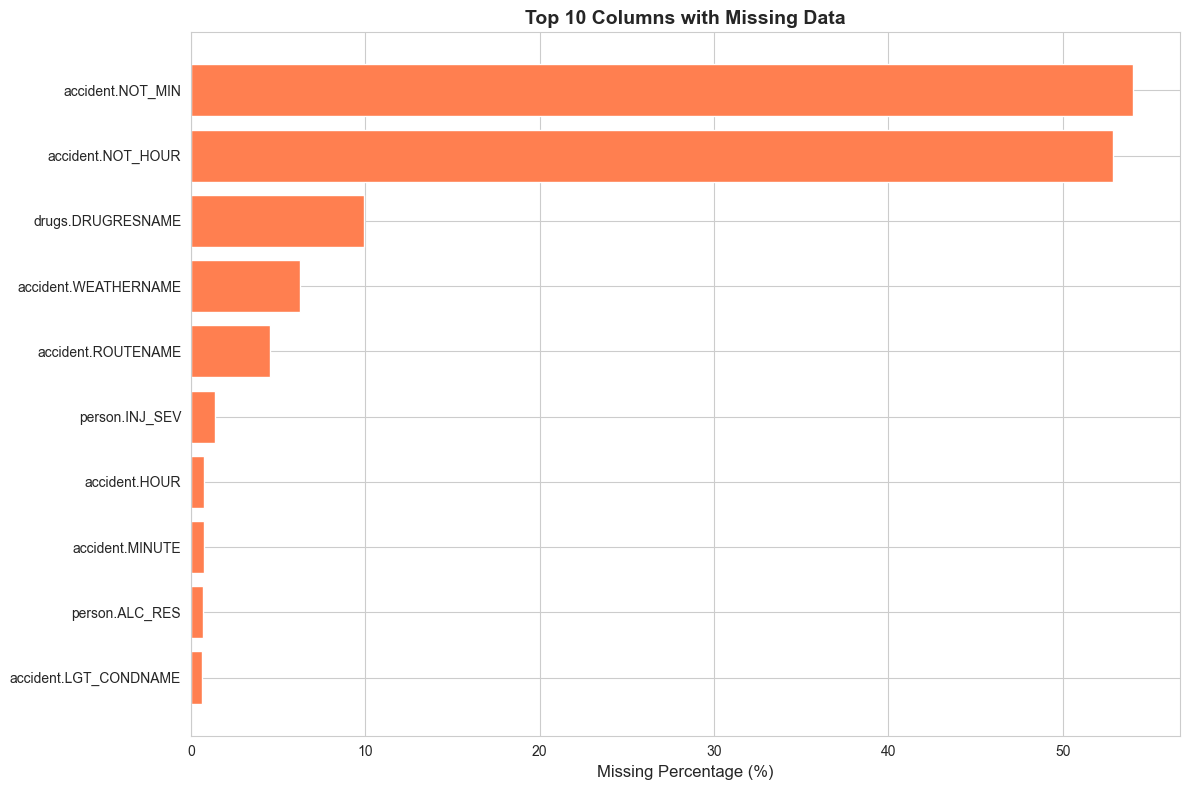

In [31]:
# Visualize missing data
fig, ax = plt.subplots(figsize=(12, 8))
missing_top = missing.head(10)
ax.barh(missing_top['Column'], missing_top['Missing_Percentage'], color='coral')
ax.set_xlabel('Missing Percentage (%)', fontsize=12)
ax.set_title('Top 10 Columns with Missing Data', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [32]:
new_cols = ['TOTAL_HARM', 'INTOXICATED_DRIVER_INVOLVED']
columns = fars_accident_cols + new_cols

joined_years_data = []

for i, datasets in enumerate(fars_data):
    joined_year_data = datasets[FARS_DATA_INDEX.ACCIDENT].copy()
    for col in new_cols:
        joined_year_data[col] = pd.NA

    for j, accident in datasets[FARS_DATA_INDEX.ACCIDENT].iterrows():
        num_persons = accident['PERSONS']
        person_row_number = datasets[FARS_DATA_INDEX.PERSON].index[datasets[FARS_DATA_INDEX.PERSON]['ST_CASE'] == accident['ST_CASE']][0]
        drugs_row_number = datasets[FARS_DATA_INDEX.DRUGS]['ST_CASE'].index[datasets[FARS_DATA_INDEX.DRUGS]['ST_CASE'] == accident['ST_CASE']][0]
        driver_person_numbers = []
        intoxicated_driver_involved = False
        for column in new_cols:
            if column == new_cols[0]: #Add a sum for all injuries
                total_harm = 0
                for k in range(num_persons):
                    person_harm = datasets[FARS_DATA_INDEX.PERSON].loc[person_row_number + k, 'INJ_SEV']
                    if person_harm <= 4:
                        total_harm += person_harm
                    elif person_harm == 5: #Injured, but unknown severity
                        total_harm += 1
                joined_year_data.loc[j, column] = total_harm

            elif column == new_cols[1]: #Check if any intoxicated drivers were involved
                drunk_drivers = 0
                for k in range(num_persons):
                    bac = datasets[FARS_DATA_INDEX.PERSON].loc[person_row_number + k, 'ALC_RES']
                    per_type = datasets[FARS_DATA_INDEX.PERSON].loc[person_row_number + k, 'PER_TYP']
                    driver_person_number = datasets[FARS_DATA_INDEX.PERSON].loc[person_row_number + k, 'PER_NO']
                    if bac > 80 and bac not in list(range(995, 999)) and per_type == 1: #0.080% is the legal limit in all states, some states have additional punishments for certain higher values. Special values are assumed to be none
                        intoxicated_driver_involved = True
                        break

                    drugs_idx = drugs_row_number
                    drugs_row = datasets[FARS_DATA_INDEX.DRUGS].iloc[drugs_idx]
                    while drugs_row['ST_CASE'] == accident['ST_CASE'] and drugs_row['PER_NO'] == driver_person_number:
                        result = drugs_row['DRUGRESNAME']
                        if pd.notna(result) and (not (result in [None, 'Test Not Given', 'None Detected/Below Threshold'])):
                            intoxicated_driver_involved = True
                            break
                        if drugs_idx == len(datasets[FARS_DATA_INDEX.DRUGS]) - 1:
                            break
                        drugs_idx += 1
                        drugs_row = datasets[FARS_DATA_INDEX.DRUGS].iloc[drugs_idx]
                    
                    if intoxicated_driver_involved:
                        break

            joined_year_data.loc[j, 'INTOXICATED_DRIVER_INVOLVED'] = intoxicated_driver_involved
    joined_years_data += [joined_year_data]
joined_data = pd.concat(joined_years_data)

display(joined_data.head())

,ST_CASE,STATENAME,PEDS,PERNOTMVIT,VE_TOTAL,VE_FORMS,PVH_INVL,PERSONS,PERMVIT,COUNTYNAME,MONTH,DAY,DAY_WEEKNAME,YEAR,HOUR,MINUTE,TWAY_ID,ROUTENAME,RUR_URBNAME,FUNC_SYSNAME,RD_OWNERNAME,NHSNAME,SP_JURNAME,HARM_EVNAME,MAN_COLLNAME,RELJCT2NAME,TYP_INTNAME,REL_ROADNAME,WRK_ZONE,LGT_CONDNAME,WEATHERNAME,SCH_BUSNAME,RAIL,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,FATALS,TOTAL_HARM,INTOXICATED_DRIVER_INVOLVED
0,10001,Alabama,0,0,2,1,1,1,1,TALLADEGA (121),1,5,Friday,2018,6.00,0.00,I-20,Interstate,Rural,Interstate,State Highway Agency,This section IS ON the NHS,No Special Jurisdiction,Parked Motor Vehicle,Not a Collision with Motor Vehicle In-Transport,Non-Junction,Not an Intersection,On Shoulder,0,Dawn,Clear,No,0000000,6.00,NaN,6,15,88,88,1,4.00,True
1,10002,Alabama,0,0,1,1,0,2,2,WALKER (127),1,8,Monday,2018,0.00,48.00,I-22,Interstate,Urban,Interstate,State Highway Agency,This section IS ON the NHS,No Special Jurisdiction,Fence,Not a Collision with Motor Vehicle In-Transport,Other location within Interchange Area,Not an Intersection,On Median,0,Dark - Not Lighted,Rain,No,0000000,0.00,NaN,0,59,88,88,2,8.00,False
2,10003,Alabama,0,0,2,2,0,2,2,CHILTON (21),1,8,Monday,2018,22.00,50.00,I-65,Interstate,Rural,Interstate,State Highway Agency,This section IS ON the NHS,No Special Jurisdiction,Guardrail Face,Not a Collision with Motor Vehicle In-Transport,Non-Junction,Not an Intersection,On Roadside,1,Dark - Not Lighted,Cloudy,No,0000000,NaN,NaN,23,10,99,99,1,6.00,True
3,10004,Alabama,0,0,1,1,0,2,2,BALDWIN (3),1,9,Tuesday,2018,13.00,2.00,I-65,Interstate,Rural,Interstate,State Highway Agency,This section IS ON the NHS,No Special Jurisdiction,Guardrail Face,Not a Collision with Motor Vehicle In-Transport,Non-Junction,Not an Intersection,On Roadside,0,Daylight,Cloudy,No,0000000,13.00,NaN,13,14,88,88,1,4.00,True
4,10005,Alabama,0,0,2,2,0,2,2,JEFFERSON (73),1,19,Friday,2018,7.00,9.00,I-459,Interstate,Urban,Interstate,State Highway Agency,This section IS ON the NHS,No Special Jurisdiction,Motor Vehicle In-Transport,Front-to-Rear,Non-Junction,Not an Intersection,On Roadway,0,Daylight,Clear,No,0000000,7.00,NaN,7,28,88,88,1,6.00,False


## 4. Geographic Coverage

In [33]:
# State distribution
state_counts = joined_data['STATENAME'].value_counts().head(15)
print("Top 15 States by fatal accident Count:")
print("=" * 40)
for state, count in state_counts.items():
    pct = (count / len(joined_data)) * 100
    print(f"{state:10s} {count:>10,}  ({pct:5.2f}%)")

Top 15 States by fatal accident Count:
California     10,639  (10.13%)
Texas          10,481  ( 9.98%)
Florida         9,052  ( 8.62%)
Georgia         4,277  ( 4.07%)
North Carolina      4,128  ( 3.93%)
Tennessee       3,233  ( 3.08%)
Pennsylvania      3,226  ( 3.07%)
Ohio            3,185  ( 3.03%)
Illinois        3,032  ( 2.89%)
Arizona         3,021  ( 2.88%)
South Carolina      2,872  ( 2.73%)
Michigan        2,830  ( 2.69%)
New York        2,822  ( 2.69%)
Alabama         2,625  ( 2.50%)
Missouri        2,572  ( 2.45%)


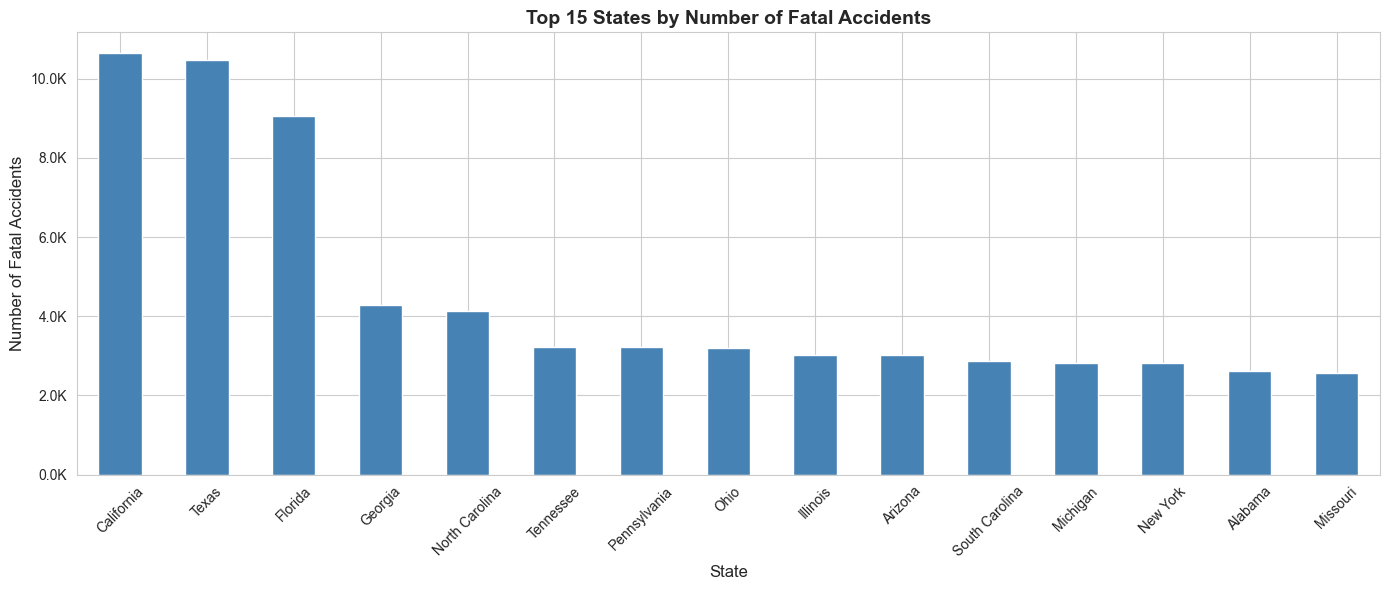

In [34]:
# Visualize state distribution
fig, ax = plt.subplots(figsize=(14, 6))
state_counts.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Top 15 States by Number of Fatal Accidents', fontsize=14, fontweight='bold')
ax.set_xlabel('State', fontsize=12)
ax.set_ylabel('Number of Fatal Accidents', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{float(x/1000)}K'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Temporal Patterns

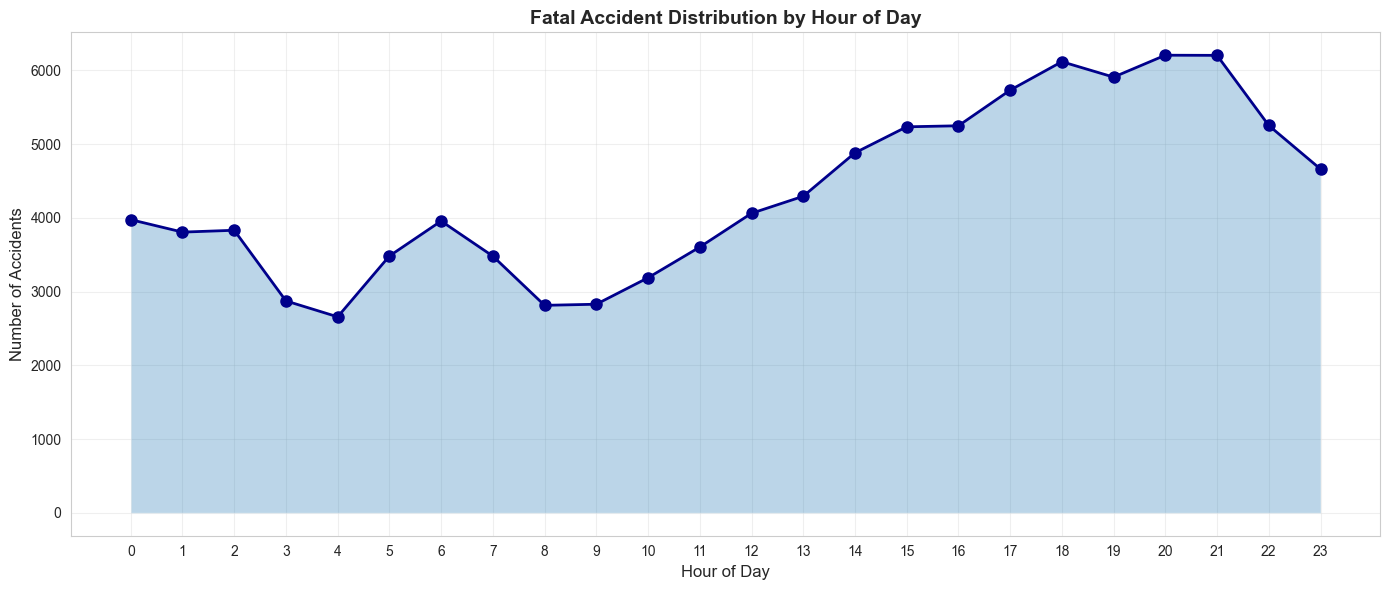

In [35]:
# Accidents by hour of day
hour_counts = joined_data['HOUR'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, markersize=8, color='darkblue')
ax.fill_between(hour_counts.index, hour_counts.values, alpha=0.3)
ax.set_title('Fatal Accident Distribution by Hour of Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Accidents', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24))
plt.tight_layout()
plt.show()

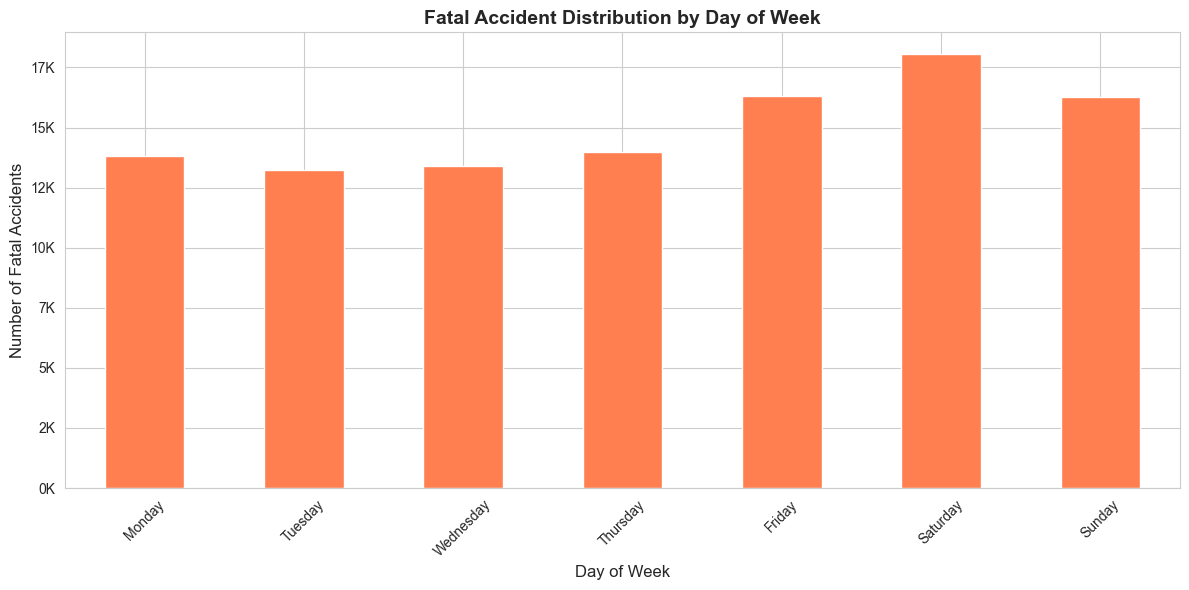

In [36]:
# Accidents by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = joined_data['DAY_WEEKNAME'].value_counts().reindex(day_order)

fig, ax = plt.subplots(figsize=(12, 6))
day_counts.plot(kind='bar', ax=ax, color='coral')
ax.set_title('Fatal Accident Distribution by Day of Week', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Number of Fatal Accidents', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observation:** The weekend has a higher number of fatal accidents compared to working days, let's dive into the hourly distribution on weekends to see why

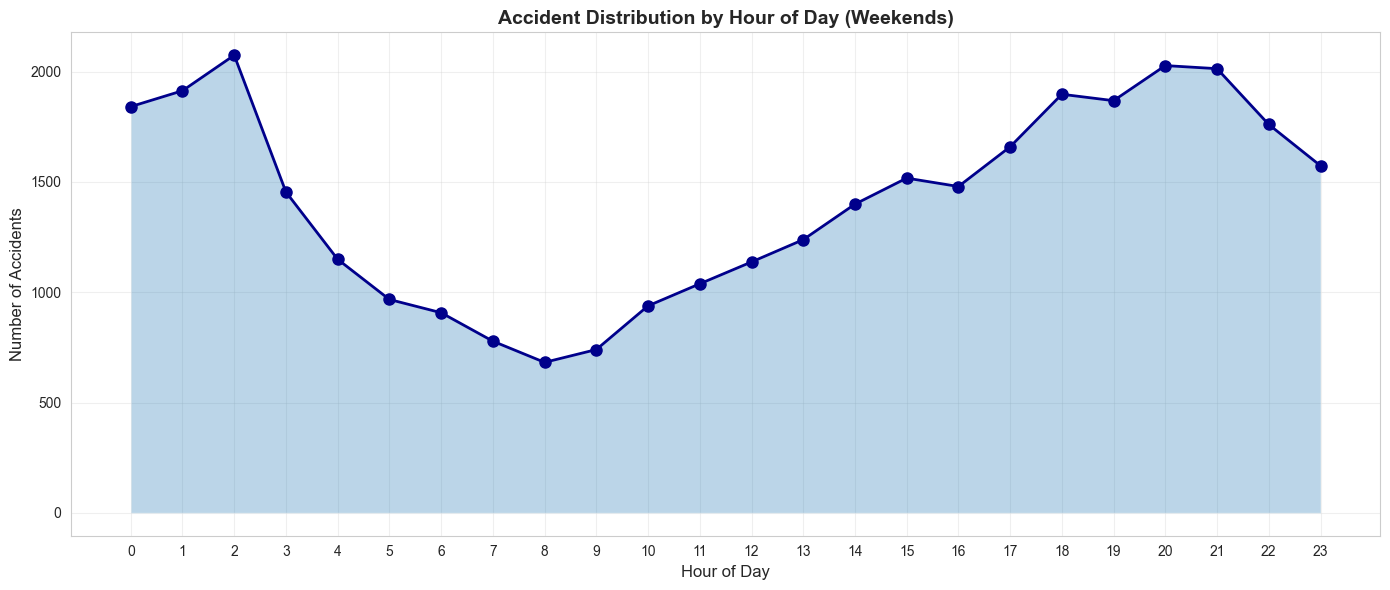


Top 10 Peak Hours for Accidents:

At 02h: 2,074 accidents (3.04x minimum)
At 20h: 2,027 accidents (2.97x minimum)
At 21h: 2,013 accidents (2.95x minimum)
At 01h: 1,913 accidents (2.80x minimum)
At 18h: 1,897 accidents (2.78x minimum)
At 19h: 1,868 accidents (2.74x minimum)
At 00h: 1,841 accidents (2.70x minimum)
At 22h: 1,760 accidents (2.58x minimum)
At 17h: 1,659 accidents (2.43x minimum)
At 23h: 1,573 accidents (2.31x minimum)

Minimum Accidents in a Single Hour (weekends): 682 accidents


In [37]:
# Accidents by hour of day on weekends

hour_counts = joined_data[joined_data['DAY_WEEKNAME'].isin(['Saturday', 'Sunday'])]['HOUR'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, markersize=8, color='darkblue')
ax.fill_between(hour_counts.index, hour_counts.values, alpha=0.3)
ax.set_title('Accident Distribution by Hour of Day (Weekends)', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Accidents', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Identify the peak hours for accidents

min_accidents = hour_counts.min()
peak_hours = hour_counts.sort_values(ascending=False).head(10)

print("\nTop 10 Peak Hours for Accidents:\n")
for hour, count in peak_hours.items():
    print(f"At {int(hour):02d}h: {count:,} accidents ({count/min_accidents:.2f}x minimum)")  

print(f"\nMinimum Accidents in a Single Hour (weekends): {min_accidents:,} accidents")

**Observation:** The rush hour patterns are less pronounced on weekends compared to weekdays. While there are still peaks in accident counts during late morning and early afternoon hours, the overall distribution is more uniform throughout the day. This suggests that weekend traffic is less influenced by traditional work commute times, leading to a more even spread of accidents across different hours.

## 6. Severity Distribution

In [46]:
# Impairment %

impairment_counts = joined_data['INTOXICATED_DRIVER_INVOLVED'].value_counts().sort_index()

print("Impairment %:")
print("=" * 50)
print("Impairment | Count      | Percentage")
print("-" * 50)
for sev, count in impairment_counts.items():
    pct = (count / len(joined_data)) * 100
    print(f"  {sev}   | {count:>10,} | {pct:>6.2f}%")

print("\nNote: Severity levels 4+, sum of all casualties in each fatal accident (1 = Possible injury, 2 = Suspected minor injury, 3 = Suspected serious injury, 4 = fatality)")


Impairment %:
Impairment | Count      | Percentage
--------------------------------------------------
  False   |     47,596 |  45.30%
  True   |     57,464 |  54.70%

Note: Severity levels 4+, sum of all casualties in each fatal accident (1 = Possible injury, 2 = Suspected minor injury, 3 = Suspected serious injury, 4 = fatality)


In [38]:
# Severity distribution
severity_counts = joined_data['TOTAL_HARM'].value_counts().sort_index()

print("Accident Severity Distribution:")
print("=" * 50)
print("Level | Count      | Percentage")
print("-" * 50)
for sev, count in severity_counts.items():
    pct = (count / len(joined_data)) * 100
    print(f"  {sev}   | {count:>10,} | {pct:>6.2f}%")

print("\nNote: Severity levels 4+, sum of all casualties in each fatal accident (1 = Possible injury, 2 = Suspected minor injury, 3 = Suspected serious injury, 4 = fatality)")

Accident Severity Distribution:
Level | Count      | Percentage
--------------------------------------------------
  0   |        116 |   0.11%
  1.0   |         31 |   0.03%
  2.0   |         79 |   0.08%
  3.0   |        119 |   0.11%
  4.0   |     62,687 |  59.67%
  5.0   |      5,325 |   5.07%
  6.0   |      8,815 |   8.39%
  7.0   |      8,632 |   8.22%
  8.0   |      5,603 |   5.33%
  9.0   |      2,548 |   2.43%
  10.0   |      3,309 |   3.15%
  11.0   |      1,787 |   1.70%
  12.0   |      1,516 |   1.44%
  13.0   |      1,124 |   1.07%
  14.0   |        845 |   0.80%
  15.0   |        513 |   0.49%
  16.0   |        524 |   0.50%
  17.0   |        320 |   0.30%
  18.0   |        257 |   0.24%
  19.0   |        238 |   0.23%
  20.0   |        154 |   0.15%
  21.0   |        114 |   0.11%
  22.0   |         96 |   0.09%
  23.0   |         60 |   0.06%
  24.0   |         42 |   0.04%
  25.0   |         27 |   0.03%
  26.0   |         26 |   0.02%
  27.0   |         18 |   0.02%
 

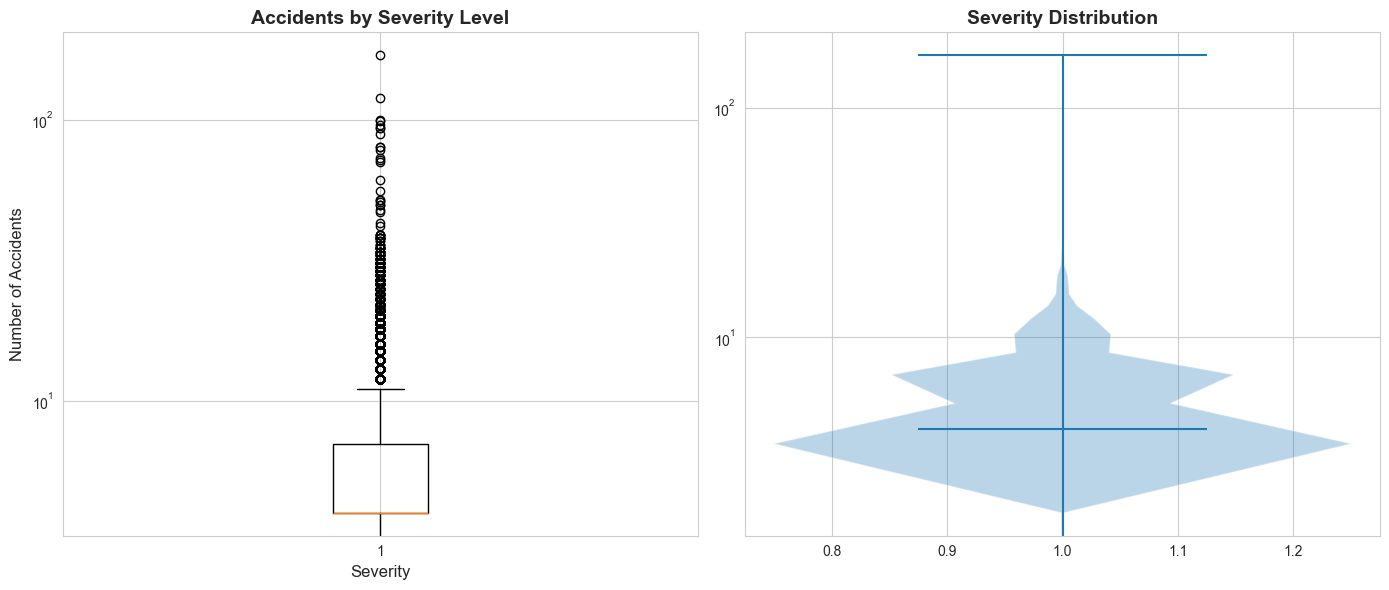

In [39]:
# Visualize severity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Box plot
ax1.boxplot(joined_data['TOTAL_HARM'])
ax1.set_title('Accidents by Severity Level', fontsize=14, fontweight='bold')
ax1.semilogy()
ax1.set_xlabel('Severity', fontsize=12)
ax1.set_ylabel('Number of Accidents', fontsize=12)

# Violin plot
ax2.violinplot(joined_data['TOTAL_HARM'].astype(float), showmeans=False, showmedians=True)
ax2.set_title('Severity Distribution', fontsize=14, fontweight='bold')
ax2.semilogy()

plt.tight_layout()
plt.show()

## 7. Weather Conditions

In [40]:
# Top weather conditions
weather_counts = joined_data['WEATHERNAME'].value_counts().head(15)

print("Top 15 Weather Conditions:")
print("=" * 60)
for i, (weather, count) in enumerate(weather_counts.items(), 1):
    pct = (count / len(joined_data)) * 100
    print(f"{i:2d}. {weather:35s} {count:>8,}  ({pct:5.2f}%)")

Top 15 Weather Conditions:
 1. Clear                                 73,133  (69.61%)
 2. Cloudy                                14,668  (13.96%)
 3. Rain                                   8,016  ( 7.63%)
 4. Fog, Smog, Smoke                       1,115  ( 1.06%)
 5. Snow                                     945  ( 0.90%)
 6. Sleet or Hail                            157  ( 0.15%)
 7. Severe Crosswinds                        148  ( 0.14%)
 8. Other                                    105  ( 0.10%)
 9. Blowing Snow                              93  ( 0.09%)
10. Freezing Rain or Drizzle                  78  ( 0.07%)
11. Blowing Sand, Soil, Dirt                  28  ( 0.03%)
12. Reported as Unknown                        0  ( 0.00%)
13. Not Reported                               0  ( 0.00%)


## 8. Infrastructure Features
Probably going to drop this, it's kind of difficult to do manually and we can probably find more useful information with some model

In [41]:
# # Infrastructure boolean columns
# infrastructure_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
#                        'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
#                        'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

# # Handle missing values first by filling with False (assuming missing means feature not present)
# df_clean = df[infrastructure_cols].fillna(False)

# infra_data = []
# for col in infrastructure_cols:
#     true_count = df_clean[col].sum()
#     false_count = len(df_clean) - true_count
#     missing_count = df[col].isnull().sum()
#     total_count = len(df)
    
#     true_percentage = (true_count / total_count) * 100
#     false_percentage = (false_count / total_count) * 100
#     missing_percentage = (missing_count / total_count) * 100
    
#     infra_data.append({
#         'Feature': col,
#         'True_Count': true_count,
#         'True_Percentage': true_percentage,
#         'False_Count': false_count,
#         'False_Percentage': false_percentage,
#         'Missing_Percentage': missing_percentage
#     })

# infra_stats = pd.DataFrame(infra_data).sort_values('True_Percentage', ascending=False)

# print("Infrastructure Feature Presence:")
# print("=" * 60)
# print(infra_stats.to_string(index=False))

In [42]:
# # Visualize infrastructure features
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.barh(infra_stats['Feature'], infra_stats['True_Percentage'], color='steelblue')
# ax.set_xlabel('Percentage of Accidents (%)', fontsize=12)
# ax.set_title('Presence of Infrastructure Features in Accidents', fontsize=14, fontweight='bold')
# ax.invert_yaxis()
# plt.tight_layout()
# plt.show()

## 9. Key Findings Summary

In [43]:
print("="*80)
print("KEY FINDINGS - FARS DATASET (2023)")
print("="*80)

print("\n📊 DATASET SIZE:")
print(f"   • Total records: {len(joined_data)}")
print(f"   • Features: {len(joined_data.columns)}")
print(f"   • Memory usage: {joined_data.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

print("\n📍 GEOGRAPHIC COVERAGE:")
print(f"   • States: {joined_data['STATENAME'].nunique()}")
print(f"   • Top state: {joined_data['STATENAME'].value_counts().index[0]} ({joined_data['STATENAME'].value_counts().iloc[0]:,} accidents)")

# print("\n⚠️ SEVERITY DISTRIBUTION:")
# for sev in sorted(joined_data['TOTAL_HARM'].unique()):
#     count = (joined_data['TOTAL_HARM'] == sev).sum()
#     pct = (count / len(joined_data)) * 100
#     print(f"   • Level {sev}: {count:>10,} ({pct:>5.2f}%)")

print("\n🌤️ WEATHER CONDITIONS:")
print(f"   • Most common: {joined_data['WEATHERNAME'].value_counts().index[0]}")

# print("\n🚦 INFRASTRUCTURE:")
# print(f"   • Traffic signals: {(df['Traffic_Signal'].sum() / len(df) * 100):.1f}%")
# print(f"   • Crossings: {(df['Crossing'].sum() / len(df) * 100):.1f}%")
# print(f"   • Junctions: {(df['Junction'].sum() / len(df) * 100):.1f}%")

print("\n⚠️ DATA QUALITY:")
print(f"   • Columns with missing data: {len(missing)} / {len(joined_data.columns)}")
print(f"   • Overall completeness: {(1 - joined_data.isnull().sum().sum() / (len(joined_data) * len(joined_data.columns))) * 100:.2f}%")

print("\n" + "="*80)

KEY FINDINGS - FARS DATASET (2023)

📊 DATASET SIZE:
   • Total records: 105060
   • Features: 42
   • Memory usage: 0.09 GB

📍 GEOGRAPHIC COVERAGE:
   • States: 51
   • Top state: California (10,639 accidents)

🌤️ WEATHER CONDITIONS:
   • Most common: Clear

⚠️ DATA QUALITY:
   • Columns with missing data: 17 / 42
   • Overall completeness: 97.12%



## 12. Save preprocessed Dataset with Modified Data Types and New Features

Lets save the dataset with modified data types and new features for quick testing in subsequent notebooks

In [45]:
output_full_path = Config.FARS_CLEANED_DIR / "fars.csv"
joined_data.to_csv(output_full_path, index=False)

print("\nDataset saved with the following details:")
print(f"✓ Cleaned dataset saved to: {output_full_path}")


Dataset saved with the following details:
✓ Cleaned dataset saved to: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\processed\fars\fars.csv
